# Seasonal Regression

The electricity demand series shows daily, weekly, and annual oscillations.  At a short time scale, I aim to capture the first two of these.

The approaches I've seen suggest Fourier Series, linear regression, and Seasonal ARIMA.
(I got quite stuck on how to detrend the series in a global fashion.)
I will focus on building models on the last two weeks of data, with the goal of predicting electricity demand based on temperature, time of day, and day of week.

## Hyndman's Multiple Seasonal Exponential Smoothing

This follows Rob Hyndman's approach towards multi-seasonal exponential smoothing.  (This generalizes the Holt-Winters smoothing to multiple seasons).
His analysis includes forecasts of electricity generation, based on utility data (from well over 10 years ago).

I chose to follow this model since most attempts at ARIMA rely on removing the seasonality, and I had hoped to just follow best practice with existing libraries.  Initial naive methods yield poor results, and failed to remove the seasonal pattern, or even worse imposed one.  An initial attempt at Fourier filtering on over a year of data also left similar trends.  Perhaps the Fourier approach could be salvaged via more sensible windowing functions. 

The original model for a variable $y_t$, with seasonal pattern with period $m$ is
\begin{align}
  y_{t} &= l_{t-1} + b_{t-1} + s_{t-m} + \epsilon_t \\
  l_{t} &= l_{t-1} + \alpha\epsilon_t \\
  b_{t} &= b_{t-1} + \beta \epsilon_t \\
  s_{t} &= s_{t-m} + \gamma \epsilon_t
\end{align}
where $l_t, b_t, s_t$ are the level, trend and seasonal patterns respectively.
The noise/innovation $\epsilon_t$ is assumed to be i.i.d. Gaussian and obey
$E[\epsilon_t]=0, E[\epsilon_t\epsilon_s]=\delta_{ts}\sigma^2$. The constants $\alpha,\beta,\gamma$ are between zero and one.  (He notes that $m+2$ estimates must be made for the initial values of the level, trend and seasonal pattern).

Hyndman's model allows multiple seasons, and allows the sub-seasonal terms to be updated more quickly than once per large season.  In utility data, the short season is the daily oscillation, while the longer season comes from the weekly oscillation induced by the work week.  For hourly data, the daily cycle has length $m_1=24$, with the weekly cycle taking $m_2=168$.  The ratio between them is $k=m_2/m_1=7.$  The number of seasonal patterns is $r\le k$.  

(I'm going to change Hyndman's notation to use $\mathbf{I}$ to denote indicator/step functions).
\begin{align}
  y_{t} &= l_{t-1}+b_{t-1} +\sum_{i=1}^r \mathbf{I}_{t,i}s_{i,t-m_1} +\epsilon_{t}\\
  s_{i,t} &= s_{i,t-m_1} + \sum_{j=1}^r\left(\gamma_{ij}\mathbf{I}_{t,j}\right) \epsilon_{t}  (i=1,2,\ldots,r) \\
  l_{t} &= l_{t-1} + b_{t-1}+\alpha\epsilon_t\\
  b_t &= b_{t-1} + \beta\epsilon_t\\
\end{align}
Here the indicator functions $\mathbf{I}_{t,i}$ are unity if $t$ is in the seasonal pattern $i$, and zero otherwise.  For utility data, this will probably be weekday and holiday/weekend.  Here $\gamma_{ij}$ denotes how much one seasonal pattern is updated based on another---Hyndman proposes a number of restrictions on these parameters.

I will extend this to include an external variables for the deviation above a given temperature, so that $y_t\rightarrow y_t+\tau_p\Theta(T_t-T_p)+\tau_{n}\Theta(T_n-T_t)$.

He suggests using the first four weeks of data to estimate the parameters, by minimizing the squared error of the one-step ahead forecast.  Apparently maximum likelihood estimation was not recommended (10 years ago).

So how to fit the parameters?  A really simple approach would be gradient descent?  Intuitively, the level is the average value, the bias is the average gradient.  The seasonality is the average seasonal pattern.  (This is the dumb STL decomposition used earlier?)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from util.get_weather_data import convert_isd_to_df, convert_state_isd
from util.EBA_util import remove_na, avg_extremes

from numpy import pi,e

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
ls data/pdx

In [2]:
try:
    df_joint=pd.read_csv('data/pdx_joint.txt',
        index_col=0, parse_dates=True)
    print('Read in PDX Frame from file')
    dem=df_joint['Demand'].copy()
    temp=df_joint['Temp'].copy()
    fore=df_joint['Forecast'].copy()
except:
    air_df = pd.read_csv('data/air_code_df.gz')
    #Just get the weather station data for cities in Oregon.
    df_weather=convert_state_isd(air_df,'OR')
    #Select temperature for Portland, OR
    msk1=np.array(df_weather['city']=='Portland')
    msk2=np.array(df_weather['state']=='OR')
    df_pdx_weath=df_weather.loc[msk1&msk2]
    #get electricity data for Portland General Electric
    df_eba=pd.read_csv('data/EBA_time.gz',index_col=0,parse_dates=True)
    msk=df_eba.columns.str.contains('Portland')
    df_pdx=df_eba.loc[:,msk]
    msk1=  df_pdx.columns.str.contains('[Dd]emand') 
    dem=df_pdx.loc[:,msk1]
    #Make a combined Portland Dataframe for demand vs weather.
    df_joint=pd.DataFrame(dem)
    df_joint=df_joint.join(df_pdx_weath)
    temp=df_joint['Temp']
    df_joint['TempShift']=150+abs(temp-150)
    df_joint = df_joint.rename(columns={df_joint.columns[0]:'Demand',
             df_joint.columns[1]:'Forecast'})
    df_joint.to_csv('data/pdx_joint.txt')

    # msk=  df_eba.columns.str.contains('Demand') \
    #     & df_eba.columns.str.contains('demand')
    # dem=df_pdx.loc[:,msk]
    # #Make a combined Portland Dataframe for demand vs weather.
    # df_joint=pd.DataFrame(dem)
    # df_joint=df_joint.join(df_pdx_weath)
    # temp=df_joint['Temp']
    # df_joint['TempShift']=150+abs(temp-150)
    # df_joint=df_joint.rename(columns={df_joint.columns[0]:'Demand',df_joint.columns[1]:'Forecast'})
    # df_joint.to_csv('data/pdx_joint.txt')


Read in PDX Frame from file


In [3]:
#clean up data, remove NA
dem = remove_na(dem)
dem = avg_extremes(dem)
temp = avg_extremes(remove_na(temp))

Number of extreme values 0. Number of zero values 148


Number of extreme values 1. Number of zero values 3
Number of NA values 56


Number of NA values 156


In [13]:
def scale_data(D,T,method='std'):
    """scale_data
    Scales both demand and temperature to have zero mean, 
    unit standard deviation.
    Returns scaled data, as well as means, and standard deviations.
    """
        
    if (method=='std'):
        scaling_df=pd.DataFrame(columns=['dem','temp'],\
                                index=['mu','std'])
        scaling_df.loc['mu','dem']=D.mean()
        scaling_df.loc['std','dem']=D.std()
        scaling_df.loc['mu','temp']=T.mean()
        scaling_df.loc['std','temp']=T.std()
        T_scale=(T-T.mean())/T.std()
        D_scale=(D-D.mean())/D.std()
    elif (method=='maxmin'):
        scaling_df=pd.DataFrame(columns=['dem','temp'],\
                                index=['max','min'])
        scaling_df.loc['max','dem']=D.max()
        scaling_df.loc['min','dem']=D.min()
        scaling_df.loc['max','temp']=T.max()
        scaling_df.loc['min','temp']=T.min()
        T_scale=(T-T.min())/(T.max()-T.min())
        D_scale=(D-D.min())/(D.max()-D.min())

    return D_scale,T_scale,scaling_df

def plot_pred(series_list,label_list):
    """make plot to compare fitted parameters"""
    for s,l in zip(series_list,label_list):
        plt.plot(s,label=l)    
    plt.legend()
    plt.show()

In [15]:
?ms

The following code tries to optimize the hyperparameters.  It seems to lock onto essentially a persistence model.  The best guess is to just use yesterday's electricity usage to predict today's. (Considering that was going to be my benchmark for simple and effective, this is somewhat disheartening.

I tried this numerically rather than via directly coding up gradient descent, since the closed form derivatives become nasty polynomials in the parameters $(\alpha,\beta,\gamma)$. The previous values $y_{t-1}$ also depend on the choice of parameters, so when you consider the derivative of the cost function
$\partial_\alpha J = T^{-1}\sum_t \partial_\alpha(y_t-\hat{y}_t)$ there is a nested sum of terms (since the parameter estimates rely on the previous errors too).

In [52]:
from EBA_seasonal.multiseasonal import multiseasonal as ms


In [43]:
start = 24*7*30
end =  start+24*7*4+24*7*20
dem_sub = dem[start:end]
temp_sub = temp[start:end]
fore_sub = fore[start:end]

alpha=0.3
beta=0.2
gamma=0.04*np.array([[1,0.4],[0.4,1]])
global icount
# icount=0
# ms_model=ms(alpha=alpha,beta=beta,gamma=gamma)
# ytot=ms_model.STL_onestep(dem_sub)

alpha2=0.1
beta2=0.1
gamma2=0.1*np.array([[1,0.2],[0.2,1]])
ms_model2=ms(alpha=alpha2,beta=beta2,gamma=gamma2)
ytot2=ms_model2.STL_dayahead(dem_sub)

-0.75

In [58]:
debug=True
ms_model2=ms(alpha=alpha2,beta=beta2,gamma=gamma2)
ypred=ms_model2.optimize_param(dem_sub,rtol=1E-6,nmax=40)

alpha 0.961937766553
beta 0.987458454835
g00 0.935620914566
g01 0.842604275744
g10 0.99
g11 0.974833339543
Failed to hit tolerance after <built-in function iter> iter

Cost: 162.792505951 162.792505951


Cost, Old Cost = 162.7925059513496,194.5900364365347


param g10 >1(!): 1.0197246145523096
J,J2,p 162.836823899 163.375996048 0.994848643893


param g10 >1(!): 1.0008388649258877
J,J2,p 161.842367022 162.575950566 0.966483421386


alpha 0.798253113222
beta 0.7841341707
g00 0.750873378056
g01 0.660157029438
g10 0.786868073404
g11 0.772494030183


Cost, Old Cost = 162.55333010689597,194.5900364365347


alpha 0.538932601202
beta 0.582129765463
g00 0.594470006645
g01 0.499929063982
g10 0.571474679297
g11 0.534068537457


Cost, Old Cost = 170.0648438472139,194.5900364365347


alpha 0.33997307411
beta 0.310102388118
g00 0.278298353242
g01 0.262658769914
g10 0.29908116964
g11 0.303435341308


Cost, Old Cost = 179.72791206939993,194.5900364365347


So while this hasn't completely converted, the trend is plain enough:
this model wants a persistence model. 

## Multiple Seasonality and Temperature

Let's now try to also include the temperature.  From earlier graphs, we'll try to fit a model of the form $A_0|T-T_0|$, i.e. electricity usage linearly increases the further the temperature is from some ideal temperature.  Let's try to first fit the temperature component, then
fit the remainder with the prior exponential smoothing model.

In lieu of having actual forecast data, I'm doing to use the actual recorded temperatures to develop the backcast. I should be able to beat the genuine day-ahead forecast, since those are relying on the weather forecast which has its own errors.  But I'm handicapped by only having a limited subset of data (the aggregate demand for a given company)
to forecast on, and guessing about which stations are important. 


In [62]:
from EBA_seasonal.multiseasonal_temp import multiseasonal_temp as ms_temp

In [335]:
start = 24*7*0
end =  start+24*7*4+24*7*24
dem_sub = dem[start:end]
temp_sub = temp[start:end]
fore_sub = fore[start:end]

alpha2=0.3
beta2=0.2
gamma2=0.05*np.array([[1,0.2],[0.2,1]])
ms_model3=ms_temp(alpha=alpha2,beta=beta2,gamma=gamma2)
ytot3=ms_model3.STL_dayahead(dem_sub,temp_sub)

In [69]:
?np.fmod

In [64]:
debug=True
alpha2=0.1
beta2=0.1
gamma2=0.01*np.array([[1,0.2],[0.2,1]])
ms_model3=ms_temp(alpha=alpha2,beta=beta2,gamma=gamma2)
ypred=ms_model3.optimize_param(dem_sub,temp_sub,rtol=1E-4,nmax=20)

UnboundLocalError: local variable 'oldJ' referenced before assignment

param g11 >1(!): 1.0649269405798594


param g00 <0(!): -3.870524806923486e-07


Iter 9.  Cost 7764570880.614731
{'alpha': 0.49522369142511735, 'beta': 0.094417224631956329, 'g00': 3.8146972656250001e-08, 'g01': 0.68561136607340301, 'g10': 0.52770177070777846, 'g11': 0.99, 'An': 9.3879412714983559, 'Ap': 10.347945089566377, 'Tn': 99.943893732225732, 'Tp': 199.87888365094958}


param g11 >1(!): 1.1688228695988632


param g00 <0(!): -1.658315106889191e-06


Iter 8.  Cost 478786196.06532
{'alpha': 0.49232998972816222, 'beta': 0.094417224522261103, 'g00': 1.52587890625e-07, 'g01': 0.60019195375986534, 'g10': 0.48266905138945182, 'g11': 0.99, 'An': 9.2621735615924479, 'Ap': 10.34010471830346, 'Tn': 99.995765707025768, 'Tp': 199.8329626434882}


param g11 >1(!): 1.0384767170573417


param g00 <0(!): -6.805117729810163e-06


Iter 7.  Cost 235180828.89094067
{'alpha': 0.48845283743887297, 'beta': 0.094417224304653755, 'g00': 6.1035156250000001e-07, 'g01': 0.57665909483490685, 'g10': 0.46965200577894517, 'g11': 0.98244088363651283, 'An': 9.1206260531718222, 'Ap': 10.332771958110374, 'Tn': 100.06278226395627, 'Tp': 199.76531573520111}


param g00 <0(!): -2.8684537847367726e-05


Iter 6.  Cost 25493053.993552346
{'alpha': 0.48325952966204561, 'beta': 0.094417222142488016, 'g00': 2.4414062500000001e-06, 'g01': 0.57235319901360981, 'g10': 0.32744861581062745, 'g11': 0.80006842884992857, 'An': 9.1584289431551511, 'Ap': 10.344488004549909, 'Tn': 100.13408564815754, 'Tp': 199.69350283151255}


param g00 <0(!): -0.00012215200494546428


Iter 5.  Cost 254176.6623518653
{'alpha': 0.44279822931283014, 'beta': 0.094417196425155309, 'g00': 9.7656250000000002e-06, 'g01': 0.43154245211536979, 'g10': 0.25382218024223469, 'g11': 0.76210190501546637, 'An': 9.3377598723122883, 'Ap': 10.368362304637838, 'Tn': 100.14490515581939, 'Tp': 199.68884451895389}


param g00 <0(!): -0.00047963700423358065


Iter 4.  Cost 174272.83319841514
{'alpha': 0.40201584694226744, 'beta': 0.094417190660399497, 'g00': 3.9062500000000001e-05, 'g01': 0.35771680863193217, 'g10': 0.2377452006707822, 'g11': 0.58449198753826059, 'An': 9.5231649969058854, 'Ap': 10.252912661352045, 'Tn': 100.16234299077578, 'Tp': 199.71059072220646}


param g00 <0(!): -0.0018370121896625921


Iter 3.  Cost 13081.968793468379
{'alpha': 0.29546703467194901, 'beta': 0.09443071306488672, 'g00': 0.00015625, 'g01': 0.27214262638053105, 'g10': 0.17995264748236406, 'g11': 0.49218697396599798, 'An': 9.6528300778041771, 'Ap': 10.160493463845773, 'Tn': 100.17137536774707, 'Tp': 199.74228285967692}


param g00 <0(!): -0.0071055514155600645


Iter 2.  Cost 6537.850021235263
{'alpha': 0.18848168217134709, 'beta': 0.094499554646978429, 'g00': 0.00062500000000000001, 'g01': 0.24637759031132186, 'g10': 0.14404893509803912, 'g11': 0.37334827852512753, 'An': 9.8127781255451794, 'Ap': 10.008181750009198, 'Tn': 100.16022800404721, 'Tp': 199.84672186735816}


param g00 <0(!): -0.017169512167272583


Iter 1.  Cost 531.3260799863366
{'alpha': 0.097365491009339167, 'beta': 0.10842520729357974, 'g00': 0.0025000000000000001, 'g01': 0.18749313633057749, 'g10': 0.059398719068424047, 'g11': 0.19388093853628177, 'An': 9.8189318468986624, 'Ap': 9.9499949040960534, 'Tn': 100.11633135592362, 'Tp': 199.99257793903374}


param g00 <0(!): -0.013010504648192525


In [338]:
per=slice('2015-12-14','2016-01-07')
plt.figure(figsize=(12,5))
plt.plot(ytot3[per],'b',label='My Predicted')
plt.plot(fore_sub[per],'g',label='Actual Predicted')
plt.plot(dem_sub[per],'r',label='Actual')
plt.legend()
plt.show()

In [266]:
ms_model3.T0

142.86281293402251

In [302]:
plt.figure()
plt.plot(dem_sub[per],'b',1500+ms_model3.Ap*np.abs(temp_sub[per]-ms_model3.Tp),'r')
plt.show()

# Thresholded Temperature Model

Let's just try to build a linear model for the temperature on top of this.
I'll assume that heating/cooling might have different coefficients, so the temperature component of the model at time $t$ is
\begin{equation}
D_t =  a_0+ a_+[T_t-T_{+}]_{+} + a_-[T_{-}-T_t]_{+},
\end{equation}
where $[f]_+=f$ if $f>0$, and is zero otherwise.  If we optimize the mean square
error, then the components can be found by solving for the values that minimize the derivatives.
If criteria is mean square error, then can solve directly for parameters
$J = sum_t[\hat{D}_t-D_t)^2$, where $\hat{D}_t$ is the true value.
We must solve $\partial J/\partial \alpha = 0 \rightarrow \sum_t \frac{\partial D_t}{\partial\alpha}(\hat{D}_t-D_t) $

Those conditions are
\begin{align}
    \sum_t(\hat{D}_t-D_t)=0  \qquad (a_0)\\
    \sum_{t\in T_\pm}[T_t-T_\pm]_\pm(\hat{D}_t-D_t)=0  \qquad (a_\pm)\\
    \sum_{t\in T_\pm}(\pm a_{\pm})(\hat{D}_t-D_t)=0  \qquad (T_\pm)\\
\end{align}


(First OOP class - absolutely ridiculous)  Will just use a pandas Dataframe - want a named set of numbers, with defined operations.  Already here.  

In [174]:
#Experimenting with OOP for making "vector" of parameters with named labels.
#Feels daft - if there's a less stupid way, I'll try to fix this.  (Just use a Dataframe!?)
#Initial attempts at getting smarter initialization (with arguments to make a dict just returned empty.
# class param_vec(dict):
#     """Class for model parameters.
#     Stores parameters in dict, with arithmatic operations.
#     """
#     #Define elementwise subtraction/addition
#     def __add__(self,x):
#         y = self.copy()
#         if isinstance(x,(int,float)):
#             for i,v in self.items():
#                 y[i]=self[i]+x
#         else:
#             for i,v in self.items():
#                 y[i]=self[i]+x[i]
#         return param_vec(y)

#     #Define elementwise subtraction/addition
#     def __radd__(self,x):
#         return param_vec.__add__(self,x)
    
#     #Define elementwise subtraction.
#     def __sub__(self,x):
#         y=self.copy()
#         if isinstance(x,(int,float)):
#             for i,v in self.items():
#                 y[i]=v-x
#         else:        
#             for i,v in self.items():
#                 y[i]=v-x[i]
#         return param_vec(y)
                
#     #Define elementwise subtraction/addition
#     def __rsub__(self,x):
#         return param_vec.__sub__(self,x)
                
#     #Define elementwise subtraction.
#     def __truediv__(self,x):
#         y=self.copy()
#         if isinstance(x,(int,float)):
#             for i,v in self.items():
#                 y[i]=v/x
#         else:        
#             for i,v in self.items():
#                 y[i]=v/x[i]
#         return param_vec(y)
                
#     #Define elementwise subtraction.
#     def __mul__(self,x):
#         y=self.copy()
#         if isinstance(x,(int,float)):
#             for i,v in self.items():
#                 y[i]=v*x
#         else:        
#             for i,v in self.items():
#                 y[i]=v*x[i]
#         return param_vec(y)
                
#     #Define elementwise subtraction.
#     def __rmul__(self,x):
#         return param_vec.__mul__(self,x)

def param_vec(names,vals):
    p=pd.Series(vals,index=names)
    return p

#might extend to contain all of the modelling stuff?          

In [171]:
class just_temp_model:
    def __init__(self,names=[],vals=[]):
        self.param= pd.Series(vals,index=names)

    def temp_model(self,T):
        """temp_model(self,T)
        Tries to fit linear model for electricity demand to temperature.
        Initially tried to allow thresholding, and different slopes for heating/cooling.  
        Will now just try simpler linear model a_p|T-T_p|.
        """ 
        m1 = T>self.param['Tp']
        m2 = T<self.param['Tn']
        y=np.zeros(T.shape)
        y[m1] = (T[m1]-self.param['Tp'])*self.param['ap']
        y[m2] = (self.param['Tn']-T[m2])*self.param['an']
        y=y+self.param['a0']
        #y = param['a0']+ param['ap']*np.abs(T-param['Tp'])
        y=pd.Series(y,name='Predicted Demand',index=T.index)
        return y

    def temp_model_grad(self,D,Dhat,T):
        """temp_model_grad
        Compute gradients of model w.r.t. parameters.
        Assumes loss-function is mean-square.
        Dhat - measured demand
        D    - predicted demand
        T    - measured temperature
        """
        m1 = T>self.param['Tp']
        m2 = T<self.param['Tn']
        Nt = len(T)
        Derr=D-Dhat
        #initialize with zeros
        dparam=param_vec(self.param.keys(),np.zeros(len(self.param)))
        dparam['a0'] = np.sum(Derr)/Nt
        #Single model
        # dparam['ap'] = np.sum( np.abs(T-param['Tp'])*Derr)/Nt
        # dparam['Tp'] = -np.sum(np.sign(T-param['Tp'])*param['ap']*Derr)/Nt
        #Double thresholded model
        dparam['ap'] = np.sum( np.abs(T[m1]-self.param['Tp'])  \
                     *(Derr[m1]))/Nt
        dparam['an'] = np.sum( (self.param['Tn']-T[m2])*(Derr[m2]))/Nt
        dparam['Tp'] = -self.param['ap']*np.sum(Derr[m1])/Nt
        dparam['Tn'] =  self.param['an']*np.sum(Derr[m2])/Nt    
        return dparam
    
    def param_fit(self,Dhat,T,alpha=0.1,rtol=1E-4,nmax=200):
        """Try to fit linear threshold model of demand to temperature.
            D - demand data
            T - temperature data
            Fits model of form:
            D ~ a_0+ a_p[T-T_p]_+ + a_n[T_n-T]_+,
            where [f]_+ =f for f>0, and 0 otherwise.

            Just use simple gradient descent to fit the model.
        """
        #make parameter estimates
        Dr = np.max(Dhat)-np.min(Dhat)
        Tr = np.max(T)-np.min(T)
        param_names=['a0','ap','an','Tp','Tn']
        param_vals=[np.mean(Dhat), 0.5*Dr/Tr, 0.5*Dr/Tr,
        np.mean(T), np.mean(T)]
        self.param=param_vec(param_names,param_vals)
        Dpred = self.temp_model(T)
        J=np.sum((Dpred-Dhat)**2)/len(Dhat)
        print('Init cost',J)
        plot_pred(Dpred,Dhat,T)
        print('Param:',self.param,"\n")    

        Ni=0
        for i in range(nmax):
            dparam=self.temp_model_grad(Dpred,Dhat,T)
            self.param=self.param-alpha*dparam
            Dpred=self.temp_model(T)
            J2=J        
            J=np.sum((Dpred-Dhat)**2)/len(Dhat)
            err_change=abs(1-J2/J)
            Ni+=1
            if (err_change<rtol):
               print("Hit tolerance {} at iter {}".format(
               err_change,Ni))
               plot_pred(Dpred,Dhat,T)                      
               return Dpred
            if(Ni%100==0):
                print("Cost, Old Cost = {},{}".format(J,J2))
                print('Param:',self.param)
                print('Param_grad:',dparam)
                print("Mean param Change {} at iter {}".format(err_change,Ni))
                plot_pred(Dpred,Dhat,T)
        print("Failed to hit tolerance after {} iter\n".format(iter))
        print("Cost:",J,J2)
        return Dpred 

    def grad_check(self,Dhat,T):
        """grad_check(Dhat,T)
        Check numerical gradients against finite difference.
            D - demand data
            T - temperature data
        """
        #make parameter estimates
        Dr = np.max(Dhat)-np.min(Dhat)
        Tr = np.max(T)-np.min(T)
        param_names=['a0','ap','an','Tp','Tn']
        #param_vals=300*np.random.random(size=5)
        param_vals=[np.mean(D),0.5*Dr/Tr,0.5*Dr/Tr,200,250]        
        self.param=param_vec(param_names,param_vals)
        print(self.param)
        Dpred = self.temp_model(T)    
        dparam=self.temp_model_grad(Dpred,Dhat,T)    
        J=0.5*np.sum((Dpred-Dhat)**2)/len(Dhat)
        eps=.1
        param2 = self.param.copy()
        for name,val in param2.items():
            self.param = param2.copy()
            self.param[name]=val+eps
            Dpred = self.temp_model(T)
            J2=0.5*np.sum((Dpred-Dhat)**2)/len(Dhat)
            numgrad = (J2-J)/eps
            print(name,numgrad,dparam[name],self.param[name])

#End of temp_model class.
#Needed to scale the data to get decent answers.  



In [172]:
dem_sub  = dem[0:24*7*1]
temp_sub = temp[0:24*7*1]

D=dem_sub
T=temp_sub
Dr = np.max(D)-np.min(D)
Tr = np.max(T)-np.min(T)

pnames=['a0','ap','an','Tp','Tn']
pval=[np.mean(D),0.5*Dr/Tr,0.5*Dr/Tr,200,100]

Tmodel=just_temp_model(names=pnames,vals=pval)

In [175]:
dem_sub  = dem[0:24*7*4]
temp_sub = temp[0:24*7*4]
#D,T,scale_df=scale_data(dem_sub,temp_sub)
Tmodel=just_temp_model(names=pnames,vals=pval)
Tmodel.grad_check(dem_sub,temp_sub)

a0 567.9050608078251 567.855060801 2801.04047619
ap 1275.4925898450892 2593.86658183 4.64077253219
an 38757.5973678712 38616.8067429 4.64077253219
Tp -79.88234915712383 -465.476677599 200.1
Tn -1892.0597531553358 2498.31148856 250.1
a0    2800.940476
ap       4.540773
an       4.540773
Tp     200.000000
Tn     250.000000
dtype: float64


# Fourier Series

Another approach that I've seen to seasonality is to just use a Fourier series.
This is similar to an approach I was using based on trying to filter the Fourier tranformed data.
This method tries to fit annual, weekly and daily oscillations to the data. 


In [56]:
#Now to do some simple Fourier Series fitting too.
class fourier_model:
    def total_fourier_series(self,D,n_max=[2,4,4]):
        """fourier_series
        Fits pandas time series D, with Fourier series. 
        Uses Pandas DateTimeIndex for times.
        Produces fourier series with annual, daily and weekly oscillations to fourier series.
        Computes coefficients, and then series.  Returns both
        D - demand (values to be fitted)
        T - DatetimeIndex
        n_max - maximum number of coefficients

        Note:Misses Holidays.
        """
        T=D.index
        T_dayofyear = T.dayofyear.values
        T_dayofweek = T.dayofweek.values
        T_hour = T.hour.values
        Tfit = [T_dayofyear/365,
        (T_dayofweek*24+T_hour)/168,
        T_hour/24]
        periods=[365,168,24]
        Nt = len(D)
        ftot = np.zeros(Nt)
        coeff=[[np.sum(D)/Nt,0]]    
        for i in range(3):
            if n_max[i]>0:
                 ci    = self.fit_fourier_series(D,Tfit[i],n_max[i])
                 ftot += self.fourier_series(ci,Tfit[i])             
            else:
                ci=None
            coeff.append(ci)
        #add on constant    
        ftot+= coeff[0][0]
        ftot=pd.Series(ftot,index=T)         
        return ftot,coeff

    def fit_fourier_series(self,D,T,nmax):
        """Fits the Fourier series to data D, on times T,
        and returns parameters.
        """
        Nt = len(D)
        #initial zero coefficients
        coeff=[]
        for n in range(1,nmax+1):
            an= 2*np.sum(np.cos(2*pi*n*T)*D)/Nt
            bn= 2*np.sum(np.sin(2*pi*n*T)*D)/Nt
            coeff.append([an,bn])
        return coeff                       

    def fourier_series(self,coeff,T):
        """fourier_series
        Make simple Fourier series with specified coefficients, 
        over time T. 
        T assumed to be in range [0,1).
        """
        i=1
        nmax=len(coeff)
        f=np.zeros(T.shape)
        #need a +1 somewhere due to 0-indexing, and not including constant
        for n in range(nmax):
            an, bn = coeff[n]
            f += an*np.cos(2*pi*(n+1)*T)+bn*np.sin(2*pi*(n+1)*T)
        return f

In [88]:
%pdb

Automatic pdb calling has been turned OFF


In [57]:
dem_sub  = dem[0:24*7*4]
temp_sub = 10*temp[0:24*7*4]

nmax = [0,4,4]

Df, Dcoeff = fourier_model.total_fourier_series(dem_sub,nmax)
plot_pred(Df,dem_sub,temp_sub)

AttributeError: 'builtin_function_or_method' object has no attribute 'dayofyear'

In [145]:
dem_scale.std()

1.0

In [294]:
%pdb

Automatic pdb calling has been turned ON


In [149]:
dem_scale,temp_scale,scale_df=scale_data(dem_sub,temp_sub)
plt.figure()
Dpred=Tmodel.param_fit(dem_scale,temp_scale)

Init cost 1.0263110440225278


Cost, Old Cost = 0.07670151030736305,0.07687407174663803
Param: a0   -0.391960
ap    0.838400
an   -0.585513
Tp   -0.690012
Tn   -0.059845
dtype: float64
Param_grad: a0   -0.006662
ap    0.017932
an    0.016383
Tp    0.028599
Tn    0.008011
dtype: float64
Mean param Change 0.00224977889722755 at iter 100
Param: a0    1.831868e-16
ap    4.542121e-01
an    4.542121e-01
Tp    2.164935e-16
Tn    2.164935e-16
dtype: float64 



Cost, Old Cost = 0.06780300101098831,0.06784870959652975
Param: a0   -0.355393
ap    0.739753
an   -0.714479
Tp   -0.859248
Tn   -0.143258
dtype: float64
Param_grad: a0   -0.002524
ap    0.002695
an    0.010862
Tp    0.002000
Tn    0.007561
dtype: float64
Mean param Change 0.0006741380891686077 at iter 200


Failed to hit tolerance after <built-in function iter> iter

Cost: 0.06780300101098831 0.06784870959652975


In [219]:
l,b,s=fit_init_params(dem_sub)

pred=predict_stl(l,b,s,dem_sub.index)

20 8


In [220]:
plt.plot(dem_sub.values,'b',temp_sub.values,'r',pred,'k')
plt.show()

# Recurrent Neural Network

Let's try throwing a neural network at this problem. (This was my ultimate goal all along.)  We'll give input method the day of the week, time of day, day of the year, and temperature.    

In [161]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.rnn import BasicRNNCell

In [ ]:
#Rambling Ideas:

#Roll-my-own network in TensorFlow.  Close to the code, may be very inefficient.  How to handle dropout, back-propagation, etc?
#Tensor-flow

In [24]:
#temp.head().index.holiday
from pandas.tseries.holiday import USFederalHolidayCalendar

#holcal=USFederalHolidayCalendar()
#t0=temp.index[0].to_pydatetime()
#t1=temp.index[-1].to_pydatetime()
#print(t0,t1)
#holind=holcal.holidays(t0,t1)
#[datetime.datetime(2015,12,25),datetime.datetime(2015,12,26)] in holind

#Add holidays in later.
#def get_holidays(Tindex):
#    """get_holidays
#    Return list of true/false based on wether a given day is a holiday or not. 
#    """
#    cal = pandas.tseries.holiday.USFederalHolidayCalendar()
#    t0 = Tindex[0]
#    t1 = Tindex[-1]
#    hols = cal.holiday(t0,t1)
#    tmsk = 

In [162]:
pi = np.pi
n_steps=24
n_inputs=1+3
n_neurons=100
n_outputs=24

np.random.seed(seed=3453)
lr=1E-3

In [179]:
def make_temptime_data(temp_mat):
    """make_input_data
    Takes input temperature data matrix (for multiple locations),
    and extends with extra indices for time of day, day of year, day of week, and holiday. 

    Input: temp_mat - pandas series of temperatures a location.  
    Output: in_mat - scaled matrix of temperatures, and scaled times of day and year.
            temp_max - maximum temperature for series (needed to invert transformations?)
            temp_min - minimum temperature
    """
    Tind = temp_mat.index
    hr = Tind.hour.values/(24-1)
    #scale length of year
    dyear = Tind.dayofyear.values/(365-1+Tind.is_leap_year.astype(int))
    dweek = Tind.dayofweek.values/(7-1)
    #scale temperature data to so that max/min correspond to [0,1]  
    temp_max = temp_mat.max(axis=0)
    temp_min = temp_mat.min(axis=0)
    temp_mat = (temp_mat-temp_min)/(temp_max-temp_min)
    in_mat= np.stack([temp_mat.values,hr,dweek,dyear]).T
    return in_mat, temp_max,temp_min

def scale_demand(dem):
    """scale_demand
    Scale demand to be on 0,1 scale.
    Input: demand - serie at 1 location
    Output: dem_scale - scaled array of values.
            dem_max, dem_min - the maximum and minimum values.
    """
    dem_scale = dem.values
    dem_max = np.max(dem_scale)
    dem_min = np.min(dem_scale)
    dem_scale = (dem_scale-dem_min)/(dem_max-dem_min)
    return dem_scale, dem_max,dem_min


temp_mat,tmax,tmin=make_temptime_data(temp)
dem_mat,dmax,dmin=scale_demand(dem)

Nt=len(dem)
Ntest = Nt//2

temp_train = temp_mat[0:Ntest,:]
temp_test = temp_mat[Ntest:,:]
dem_train = dem_mat[0:Ntest]
dem_test = dem_mat[Ntest:]


In [249]:
?plt.legend

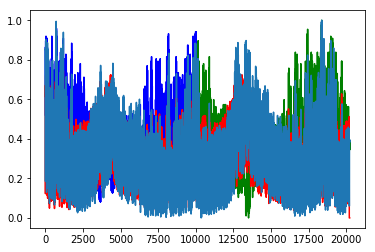

NameError: name 'right' is not defined

10108 10108
842.3333333333334
INFO:tensorflow:Restoring parameters from ./models/pdx_RNN_model


In [251]:
#n0,x_sub,y_pred=toy_predict(2.5)
print(len(np.arange(Ntest,Nt)),len(temp_mat[Ntest:,0]))
print(Nt/n_steps)
ytot=plot_whole_sample_fit(temp_mat,dem_mat,Ntest,n_steps)

In [220]:
temp_mat.shape

(20216, 4)

In [326]:
def plot_insample_fit(tstart):
    """plot_insample_fit(tstart)
    Plot the predictions of the trained model
    on the "training" set with different noise, and longer
    times.
    """

    n0,x_sub,y_pred=toy_predict(Xsig,t,tstart)
    plt.figure()
    ind=np.arange(n0,n0+n_outputs)
    plt.plot(x_sub[:,0],x_sub[:,1],'b')
    plt.plot(t[ind],y_pred,'r')
    plt.plot(t[ind],Xsig[ind])
    plt.show()

def plot_outsample_fit(tstart):
    """plot_outsample_fit

    Plot the predictions of the trained model
    on a "test" set with different noise, and longer
    times.
    """
    #pull in the inputs, and predictions
    n0,x_sub,y_pred=toy_predict(X_test,t2,tstart)
    plt.figure()
    ind=np.arange(n0,n0+n_outputs)
    plt.plot(x_sub[:,0],x_sub[:,1],'b',label='Input')
    #now plot against the test sets defined earlier
    plt.plot(t2[ind],X_test[ind],'b',label='Test')
    try:
        plt.plot(t[ind],Xsig[ind],'g',label='Training')
    except:
        print('out of range for training data? no traing plot')
    plt.plot(t2[ind],y_pred,'r',label='Predicted')
    plt.show()

def plot_whole_outsample_fit():
    """plot_whole_outsample_fit

    Plot ALL of the predictions of the trained model
    on a "test" set with different noise, and longer
    times.  Concatenates the predicted results together.  
    """
    #pull in the inputs, and predictions
    nmax=int((2*Nt-1)/n_outputs)
    y_tot=np.array([])
    for i in range(nmax-1):
        tstart=(n_steps+i*n_outputs)*dt
        n0,x_sub,y_pred=toy_predict(X_test,t2,tstart)
        y_tot=np.append(y_tot,y_pred)
        print('t0',tstart,i)
    plt.figure()
    ind=np.arange(n0,n0+n_outputs)
    #now plot against the test sets defined earlier
    plt.plot(t2,X_test,'b',label='Test')
    try:
        plt.plot(t,Xsig,'g',label='Training')
    except:
        print('out of range for training data? no traing plot')
    plt.plot(t2[n_steps+1:],y_tot,'r',label='Predicted')
    plt.show()



In [2]:
ytot

NameError: name 'ytot' is not defined